# Sensitivity Analysis of Longtermist Assumptions on Impact

#### Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Sensitivity to Baseline Risk

In [3]:
def survival_prob_fn(period, risk):
    """Returns the probability of surviving through *period, given constant period *risk."""
    return (1 - risk) ** period

def get_value_of_baseline_scenario(risk, num_periods):
    """The expected value of a scenario with constant period *risk, existing for *num_periods."""
    risk_survival_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, risk))
    survival_probs = risk_survival_prob_fn(np.arange(1, num_periods + 1))
    return survival_probs.sum()

def get_baseline_intervention_impact(intervention_effect, baseline_risk, num_periods):
    """The expected value of an intervention that reduces period risk from *baseline_risk by *intervention_effect,
    for a world existing for *num_periods"""
    
    if intervention_effect > baseline_risk:
        ValueError("Intervention effect greater than risk.")
    
    # without intervention
    base_value = get_value_of_baseline_scenario(baseline_risk, num_periods)
    
    # with intervention
    intervention_value = get_value_of_baseline_scenario(baseline_risk - intervention_effect, num_periods)
    
    return intervention_value - base_value

### How E[L] Changes with Risk

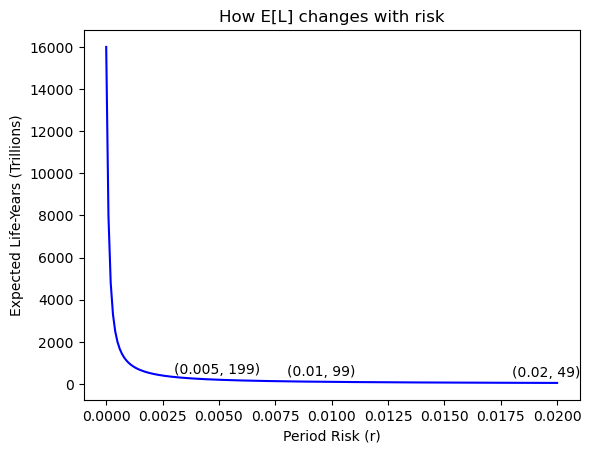

In [7]:
# parameters
n_periods = 16000
risks = np.arange(0.0000, 0.0201, 0.0001)

# outcome
evs = np.empty(len(risks))

# calculation
for i in range(len(risks)):
    evs[i] = get_value_of_baseline_scenario(risks[i], n_periods)
    
plt.plot(risks, evs, color="b")
plt.annotate(f"({risks[50]:.3f}, {evs[50]:.0f})", (risks[50] - 0.002, evs[50]+ 300))
plt.annotate(f"({risks[100]:.2f}, {evs[100]:.0f})", (risks[100] - 0.002, evs[100]+ 300))
plt.annotate(f"({risks[200]:.2f}, {evs[200]:.0f})", (risks[200] - 0.002, evs[200]+ 300))
plt.title("How E[L] changes with risk")
plt.xlabel("Period Risk (r)")
plt.ylabel("Expected Life-Years (Trillions)")
plt.show()

### Comparing Different Reductions in risk

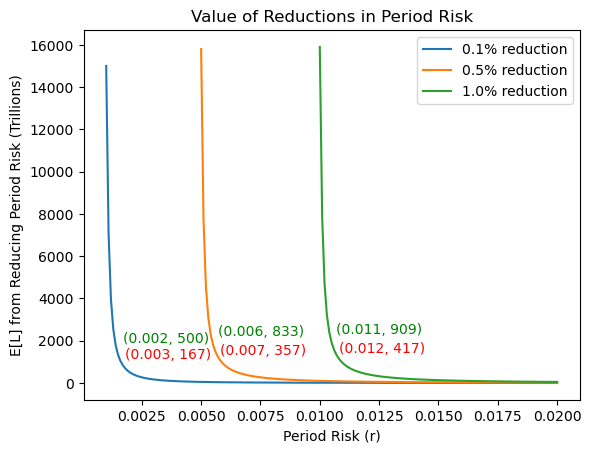

In [9]:
# parameters
n_periods = 16000

# intervention effects
reductions = [0.001, 0.005, 0.01]

for reduction in reductions:
    # risks considered, bounded by intervention effect
    risks = np.arange(reduction, 0.0201, 0.0001)

    # outcome
    reduction_impact = np.empty(len(risks))

    # calculation
    for i in range(len(risks)):
        reduction_impact[i] = get_baseline_intervention_impact(reduction, risks[i], n_periods)

    # plot line and annotate
    plt.plot(risks, reduction_impact, label=f"{reduction*100:.1f}% reduction")
    index = 10
    plt.annotate(f"({risks[index]:.3f}, {reduction_impact[index]:.0f})", (risks[index] - 0.0003, reduction_impact[index]+ 1400), color="g")
    index = 20
    plt.annotate(f"({risks[index]:.3f}, {reduction_impact[index]:.0f})", (risks[index] - 0.0012, reduction_impact[index]+ 1000), color="r")

# Add labels and display
plt.legend()
plt.title("Value of Reductions in Period Risk")
plt.xlabel("Period Risk (r)")
plt.ylabel("E[L] from Reducing Period Risk (Trillions)")
plt.show()

## Sensitivity to Intervention Discounting

In [12]:
def survival_prob_fn(period, risk):
    """Returns the probability of surviving through *period, given constant period *risk."""
    return (1 - risk) ** period

def get_value_of_baseline_scenario(risk, num_periods):
    """The expected value of a scenario with constant period *risk, existing for *num_periods."""
    risk_survival_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, risk))
    survival_probs = risk_survival_prob_fn(np.arange(1, num_periods + 1))
    return survival_probs.sum()

def get_value_of_discounted_intervention_scenario(intervention_effect, baseline_risk, num_periods, discount_factor):
    # calculate discounted intervention effects on period risks
    intervention_effect_fn = np.vectorize(lambda period: intervention_effect * (discount_factor ** period))
    period_intervention_effects = intervention_effect_fn(np.arange(num_periods))
    
    # calculate new period risks
    period_risks = baseline_risk - period_intervention_effects
    
    survival_probs = np.empty(num_periods)
    
    # calculate cumulative survival probabilities for each period
    prob_prev_survival = 1
    for period in range(num_periods):
        survival_probs[period] = prob_prev_survival * (1 - period_risks[period])
        prob_prev_survival = survival_probs[period]
        
    return survival_probs.sum()

def get_discounted_intervention_impact(intervention_effect, baseline_risk, num_periods, discount_factor):
    if intervention_effect > baseline_risk:
        ValueError("Intervention effect greater than risk.")
    
    # without intervention
    base_value = get_value_of_baseline_scenario(baseline_risk, num_periods)
    
    # with intervention
    intervention_value = get_value_of_discounted_intervention_scenario(intervention_effect, baseline_risk, num_periods, discount_factor)
    
    return intervention_value - base_value

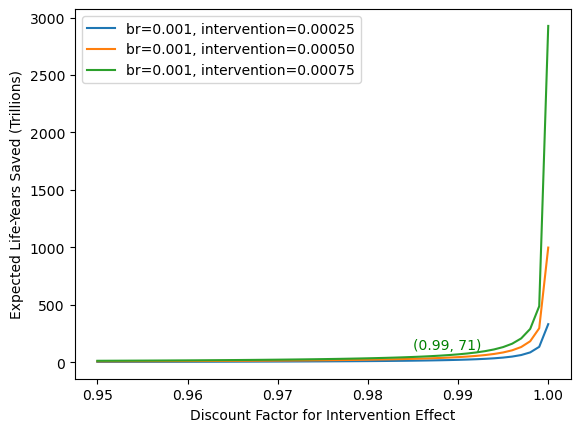

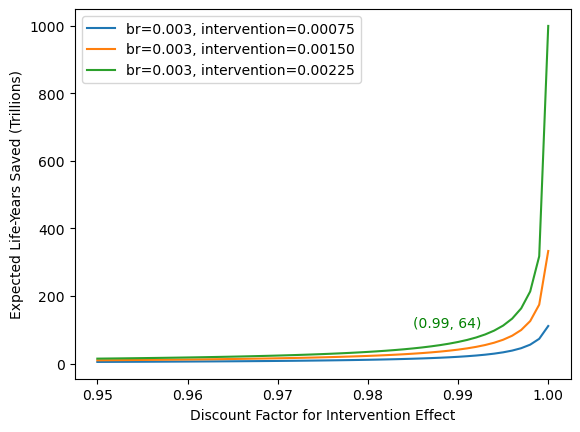

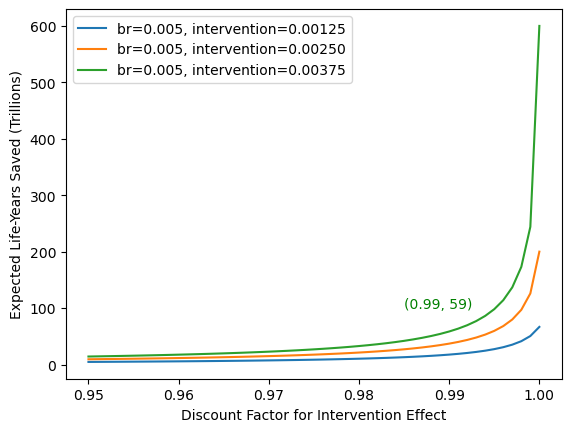

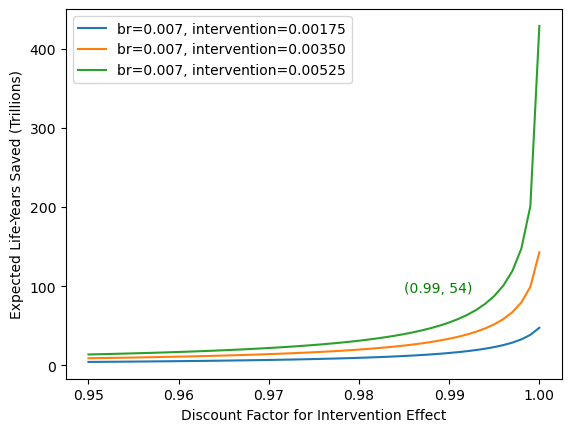

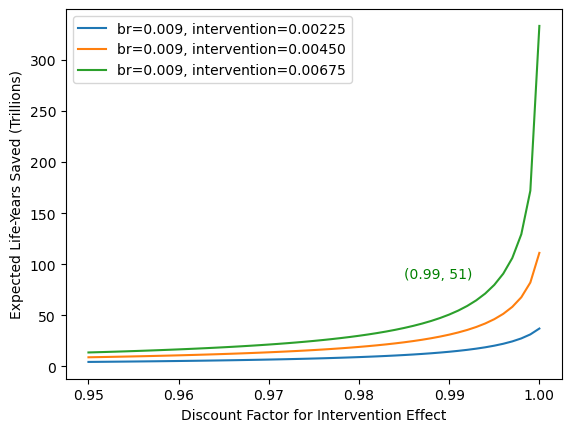

In [13]:
# params
n_periods = 16000

# for baseline risk, intervention effect pairs
base_risks = np.arange(0.001, 0.011, 0.002)
for base_risk in base_risks:
    intervention_effects = np.arange(base_risk / 4.0, base_risk, base_risk / 4.0)
    for intervention_effect in intervention_effects:
        if intervention_effect == base_risk:
            continue
        
        # measure impacts for discount factors
        discount_factors = np.arange(0.95, 1.001, 0.001)
        impacts = np.empty(len(discount_factors))
        for factor_i in range(len(discount_factors)):
            impacts[factor_i] = get_discounted_intervention_impact(intervention_effect, base_risk, n_periods, discount_factors[factor_i])
        
        
        plt.plot(discount_factors, impacts, label=f"br={base_risk:.3f}, intervention={intervention_effect:.5f}")
    plt.annotate(f"({discount_factors[40]:.2f}, {impacts[40]:.0f})", (discount_factors[40] - 0.005, impacts[40] * 1.7), color="g")
    plt.xlabel("Discount Factor for Intervention Effect")
    plt.ylabel("Expected Life-Years Saved (Trillions)")
    plt.legend()
    plt.show()

## Sensitivity to S-risks

In [15]:
def survival_prob_fn(period, risk):
    """Returns the probability of surviving through *period, given constant period *risk."""
    return (1 - risk) ** period

def get_value_of_s_risk_scenario(period_x_risk, num_periods, period_s_risk_chance, s_risk_severity):
    # get survival probs for each period
    risk_survival_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, period_x_risk))
    survival_probs = risk_survival_prob_fn(np.arange(1, num_periods + 1))
    
    # get non-s-risk probs for each survival period
    prob_normal_fn = np.vectorize(lambda i: (1-period_s_risk_chance) ** i)
    probs_of_normal = prob_normal_fn(np.arange(1, n_periods + 1))

    # get s-risk probs for each survival period
    probs_of_s_risk = 1 - probs_of_normal
    
    return (survival_probs * (probs_of_normal + probs_of_s_risk * s_risk_severity)).sum()

def get_s_risk_intervention_impact(intervention_effect, baseline_risk, num_periods, period_s_risk_chance, s_risk_severity):
    if intervention_effect > baseline_risk:
        ValueError("Intervention effect greater than risk.")
    
    # without intervention
    base_value = get_value_of_s_risk_scenario(baseline_risk, num_periods, period_s_risk_chance, s_risk_severity)

    # with intervention
    intervention_value = get_value_of_s_risk_scenario(baseline_risk - intervention_effect, num_periods, period_s_risk_chance, s_risk_severity)

    return intervention_value - base_value

def graph_s_risk_sensitivities(base_risks, relative_risk_reduction_factor, period_s_risks, s_risk_severities, n_periods):
    for base_risk in base_risks:
        intervention_effects = np.arange(base_risk / relative_risk_reduction_factor, base_risk, base_risk / relative_risk_reduction_factor)
        for intervention_effect in intervention_effects:
            if intervention_effect == base_risk:
                continue
            for s_risk_severity in s_risk_severities:
                impacts = []
                for period_s_risk in period_s_risks:
                    impacts += [get_s_risk_intervention_impact(intervention_effect, base_risk, n_periods, period_s_risk, s_risk_severity)]
                # add line for (s-risk chance, severity) pair to graph for current (baseline risk, intervention effect) pair
                plt.plot(period_s_risks, impacts, label=f"severity={s_risk_severity:.1f}")

            # Create graph for given (baseline risk, intervention effect) pair
            plt.legend()
            plt.title(f"Intervention of {intervention_effect:.5f}, with baseline risk {base_risk:.5f}")
            plt.ylabel("Expected Life-Years Saved (Trillions)")
            plt.xlabel("Period S-risk")
            plt.show()

### Larger S-risk Chances and Severities

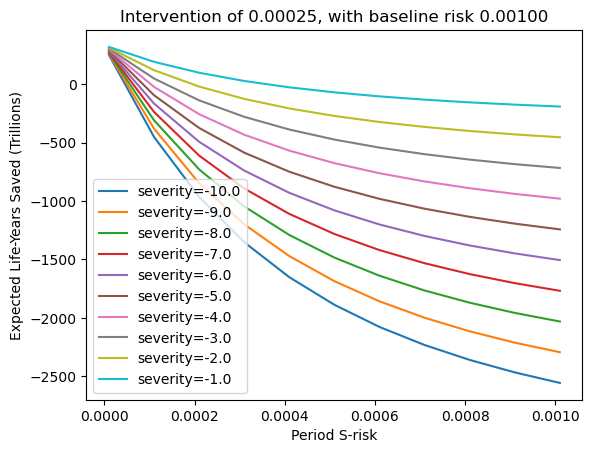

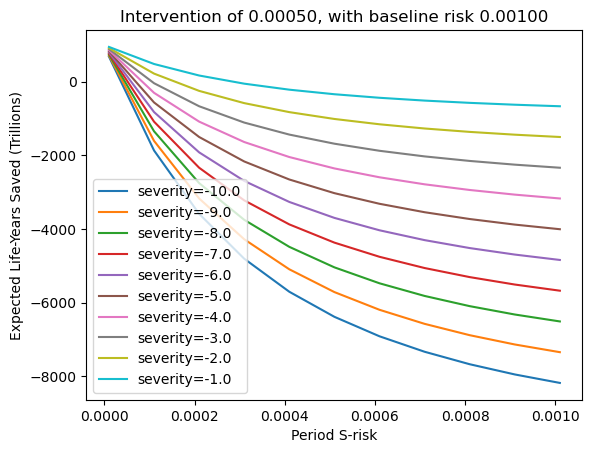

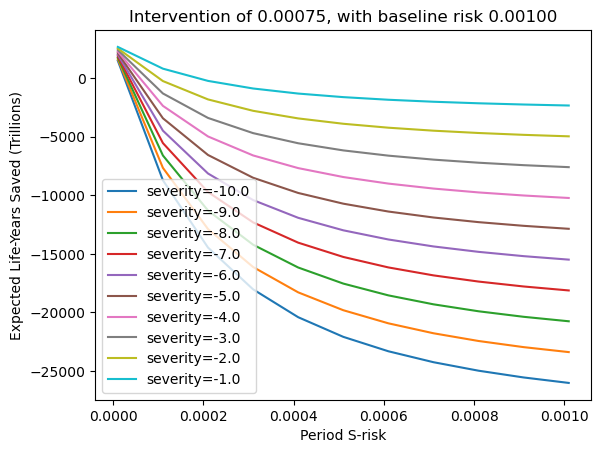

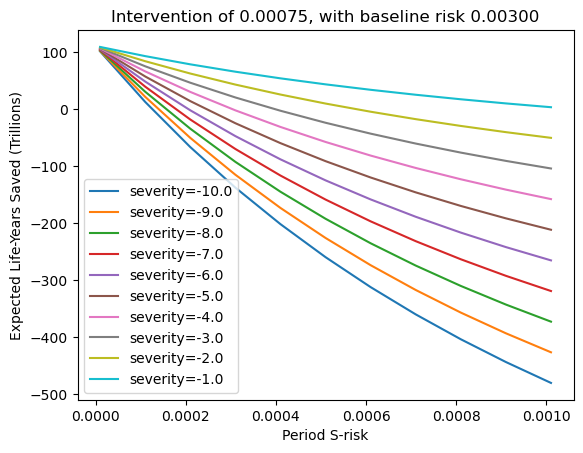

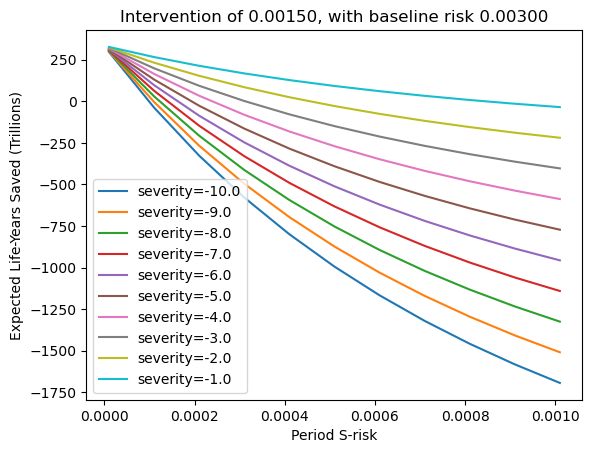

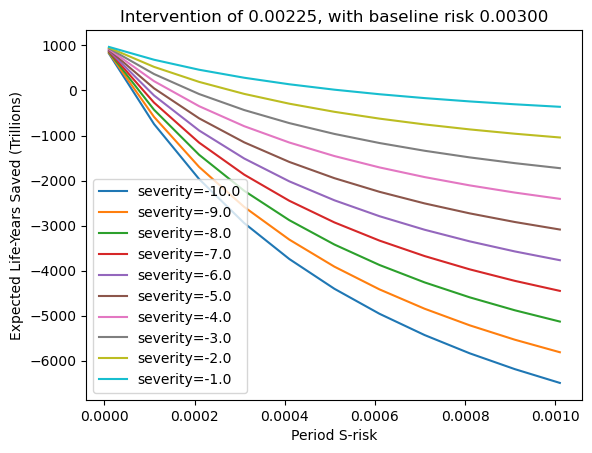

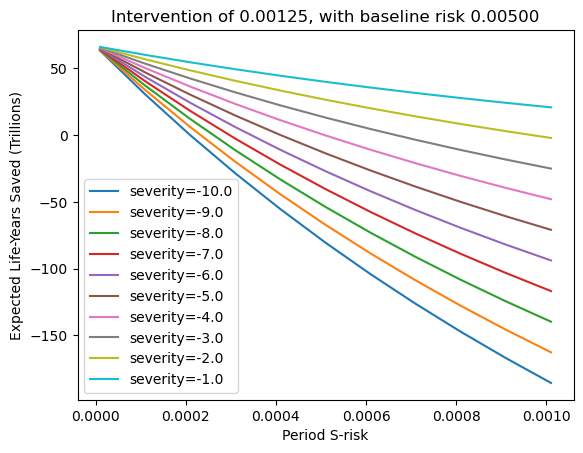

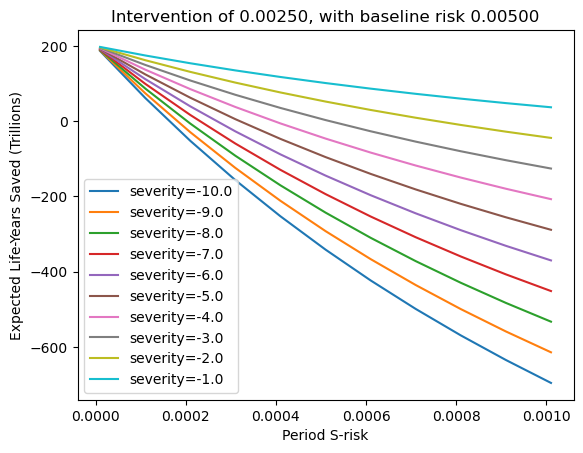

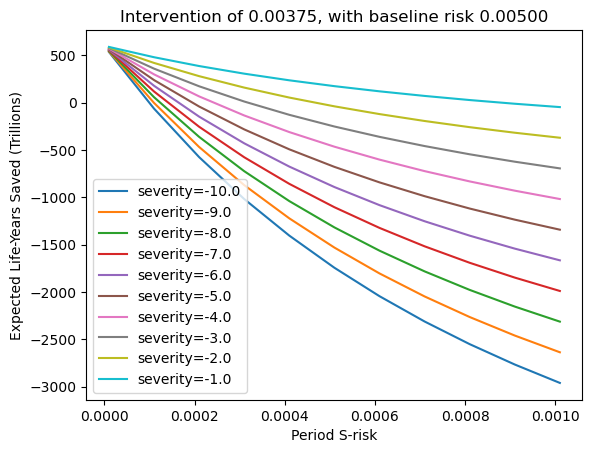

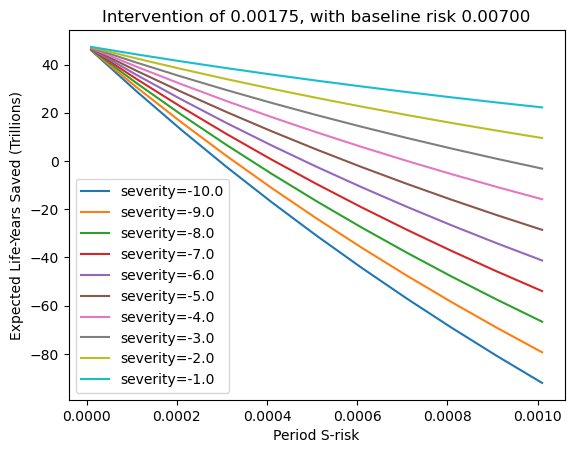

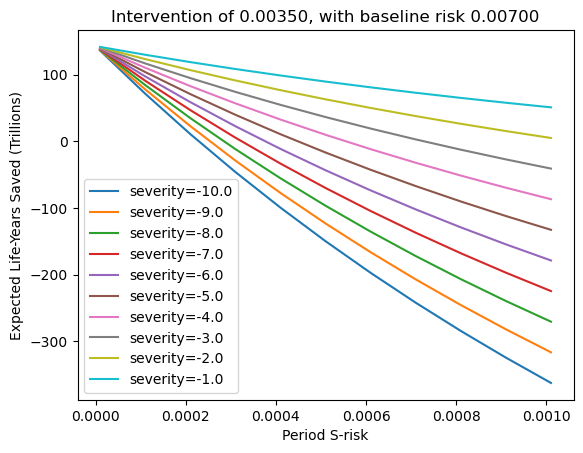

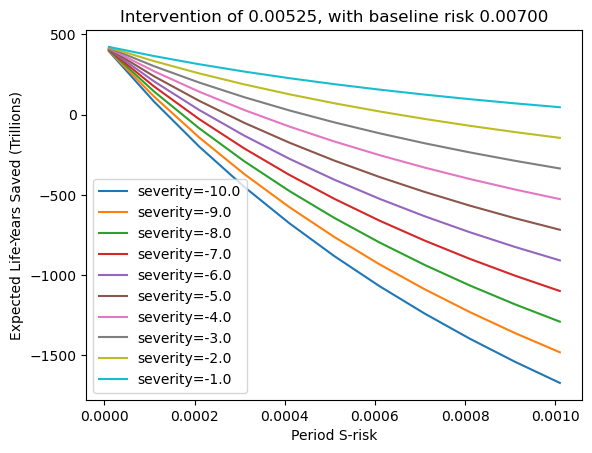

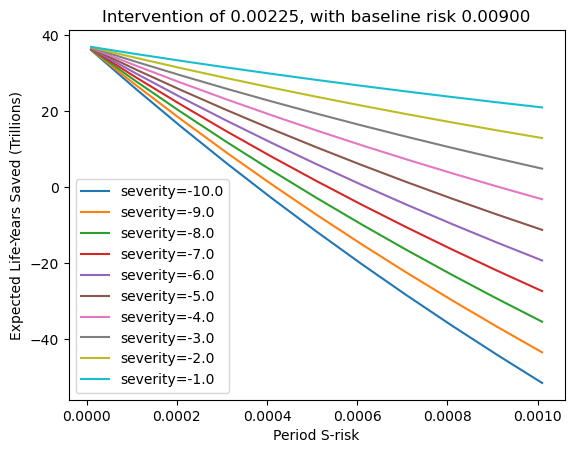

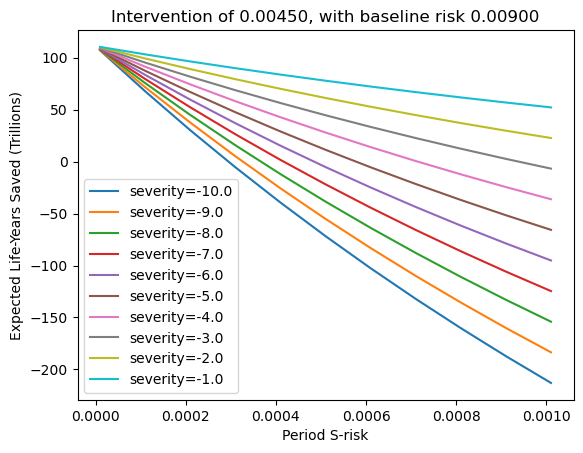

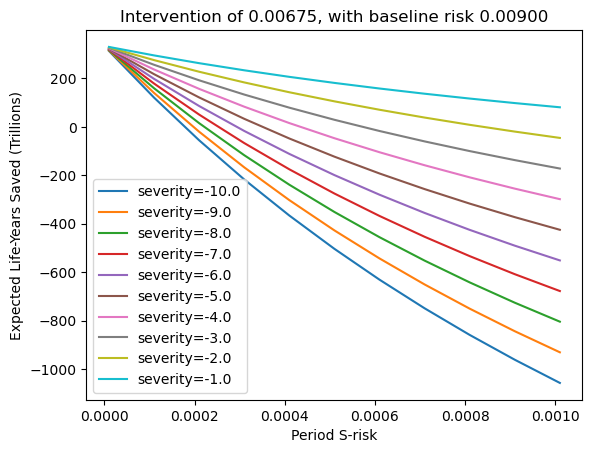

In [17]:
# params
n_periods = 16000
base_risks = np.arange(0.001, 0.011, 0.002)
relative_risk_reduction_factor = 4.0 # determines the relative sizes (and number) of the intervention effects graphed
s_risk_severities = np.arange(-10, 0, 1)
period_s_risks = np.arange(0.00001, 0.0011, 0.0001)

graph_s_risk_sensitivities(base_risks, relative_risk_reduction_factor, period_s_risks, s_risk_severities, n_periods)

### Smaller S-risk Chances

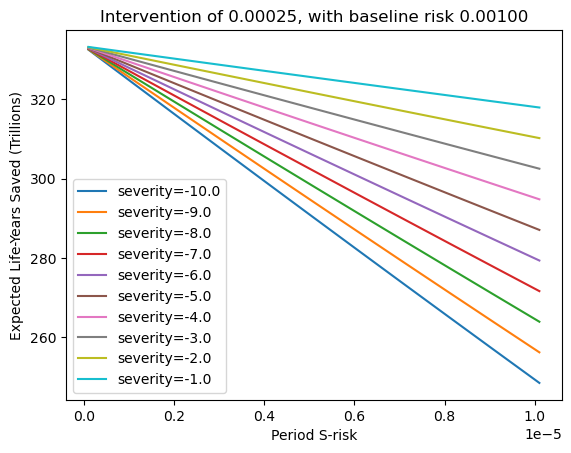

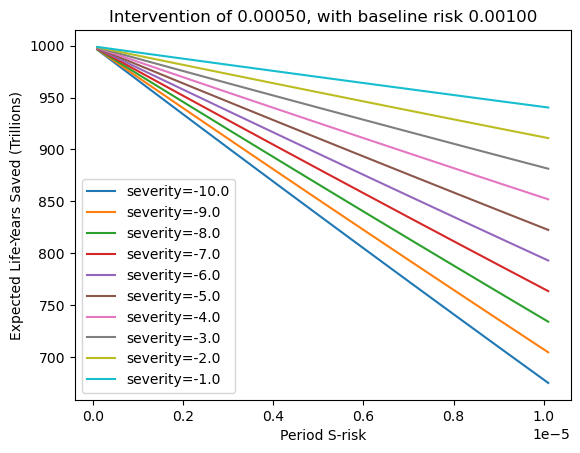

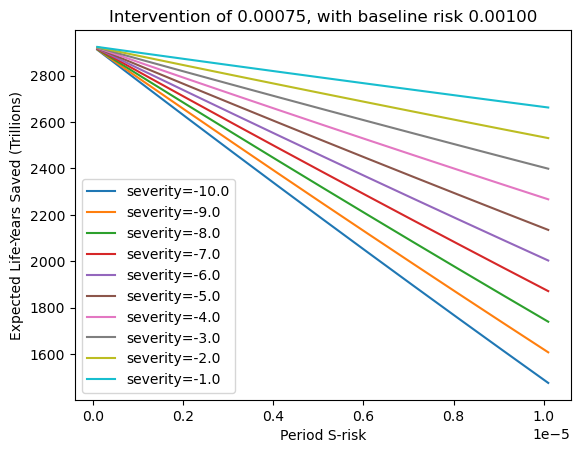

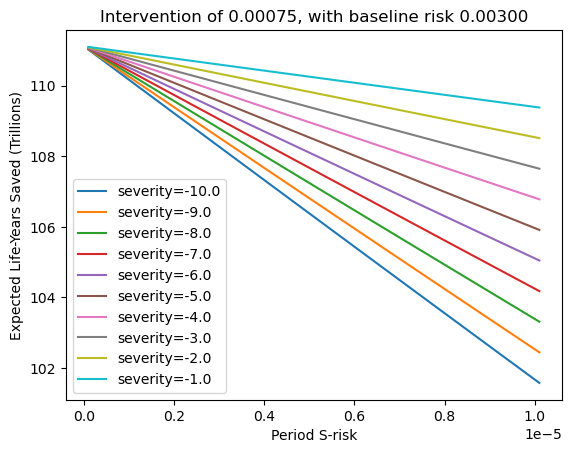

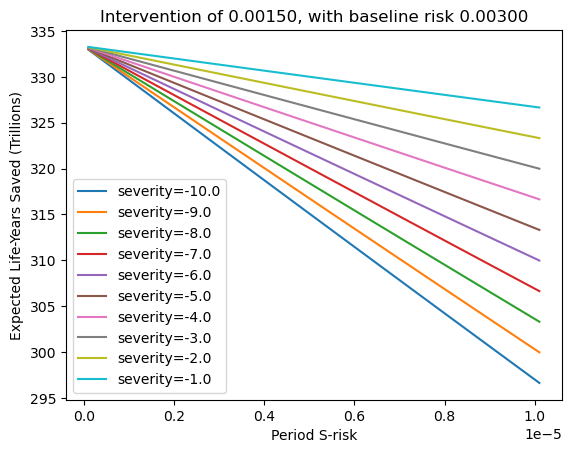

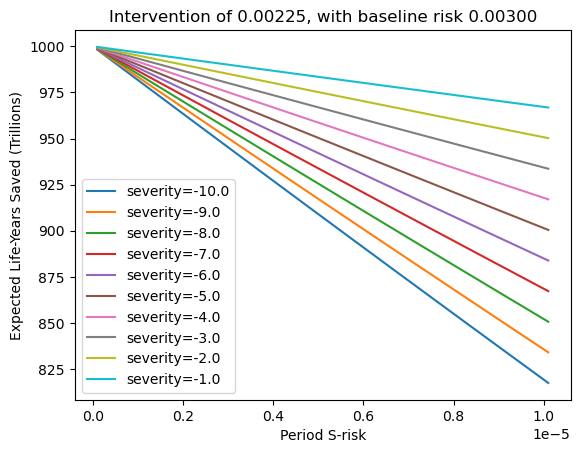

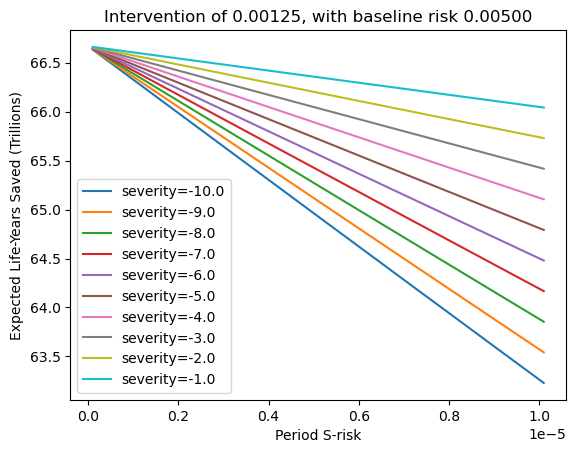

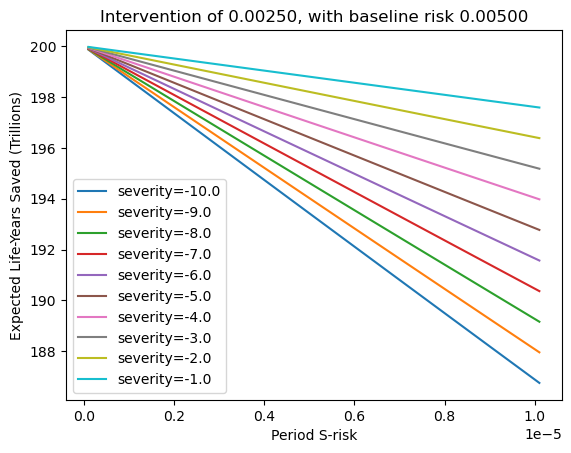

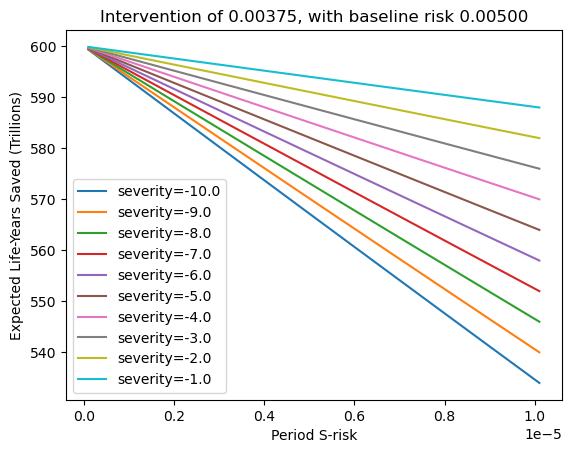

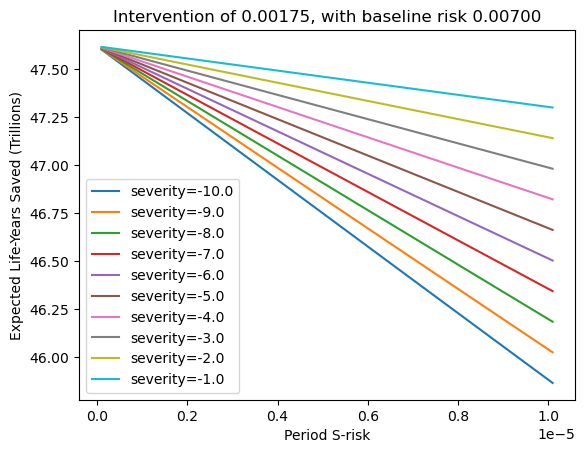

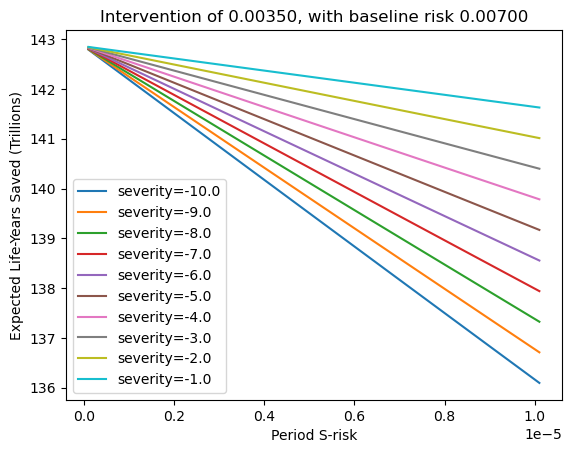

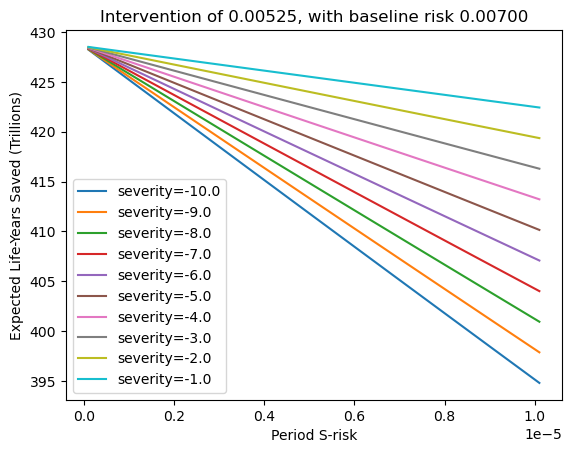

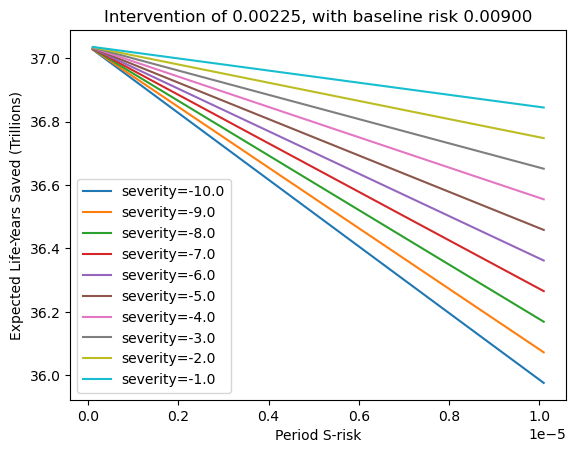

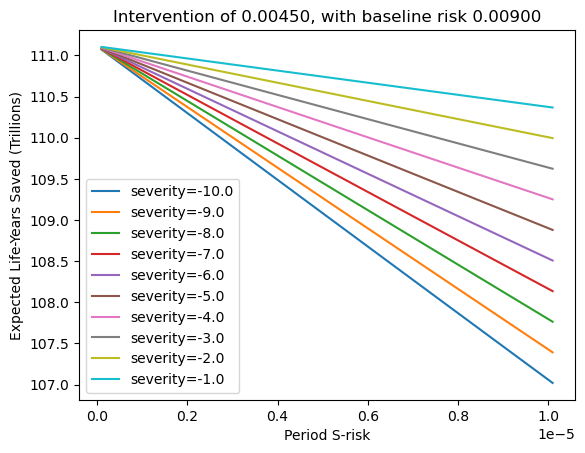

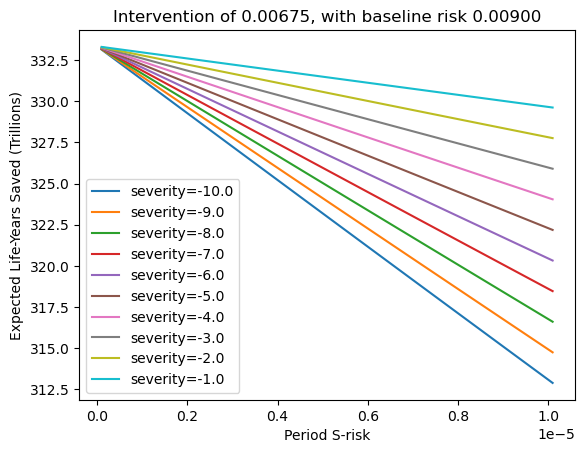

In [19]:
# params
n_periods = 16000
base_risks = np.arange(0.001, 0.011, 0.002)
relative_risk_reduction_factor = 4.0 # determines the sizes (and number) of the intervention effects graphed
s_risk_severities = np.arange(-10, 0, 1)
period_s_risks = np.arange(0.0000001, 0.000011, 0.000001)

graph_s_risk_sensitivities(base_risks, relative_risk_reduction_factor, period_s_risks, s_risk_severities, n_periods)

### Smaller S-risk Chances and Severities

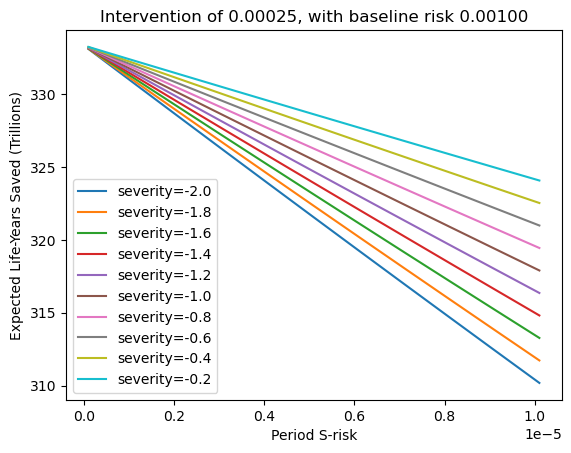

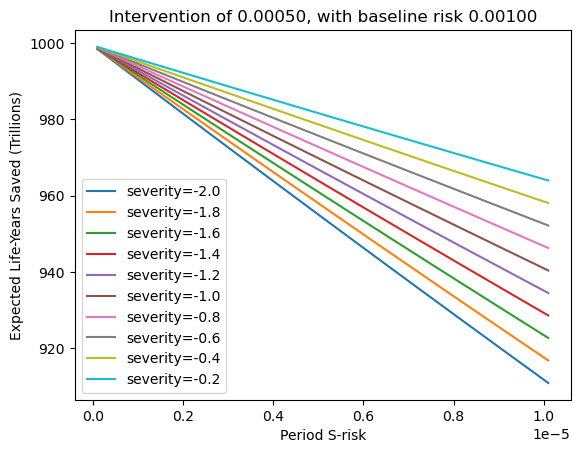

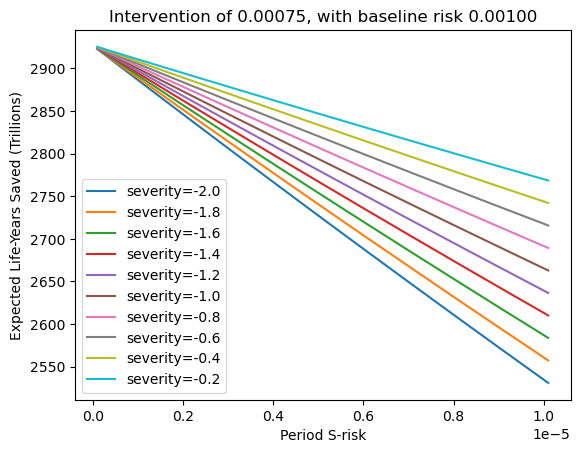

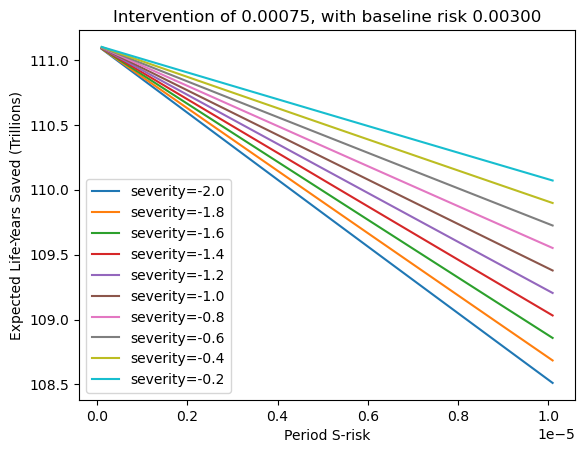

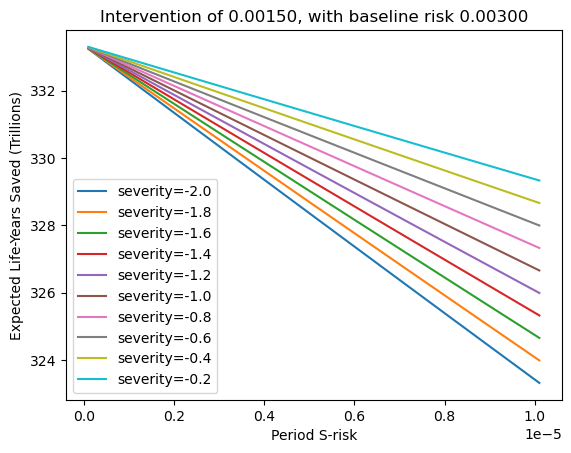

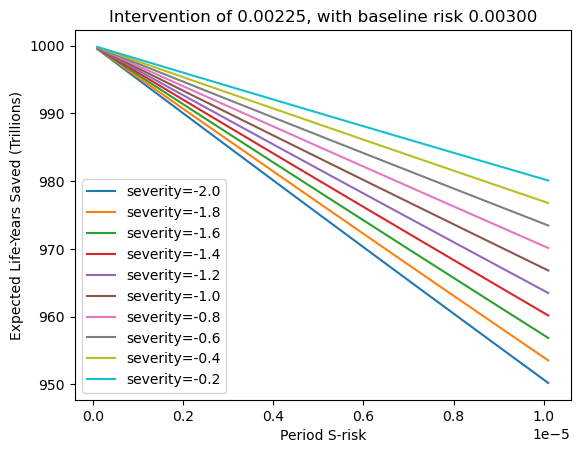

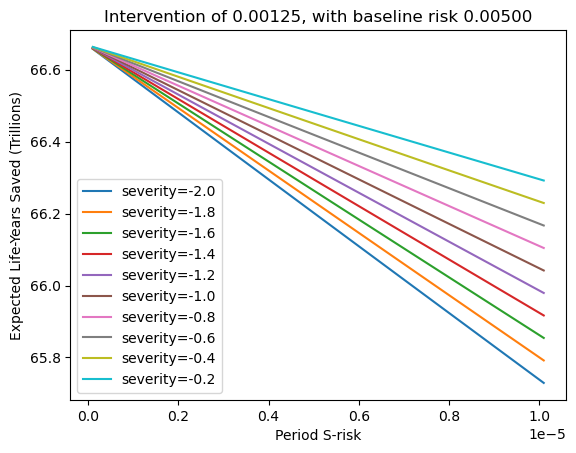

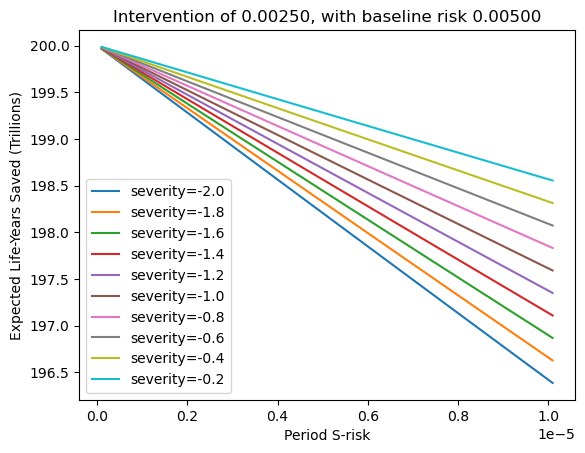

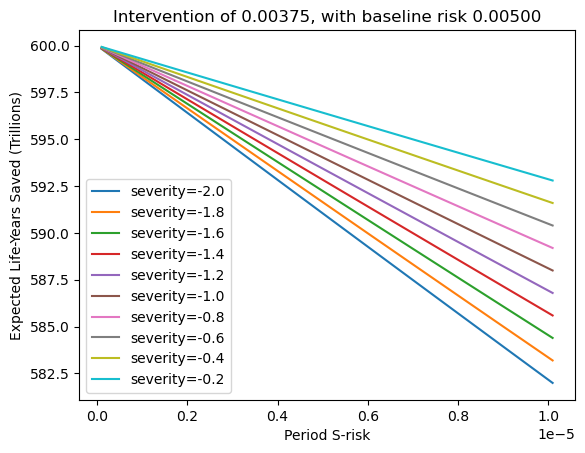

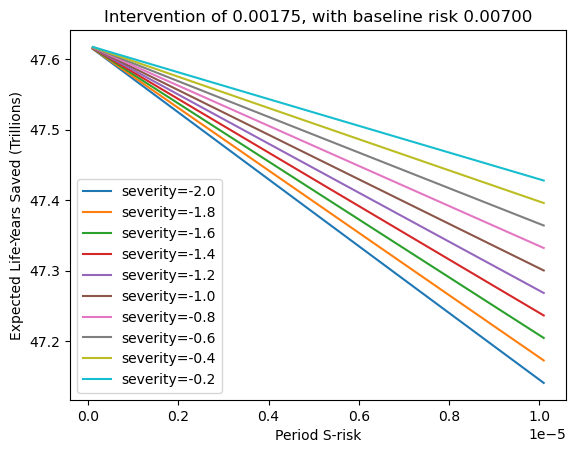

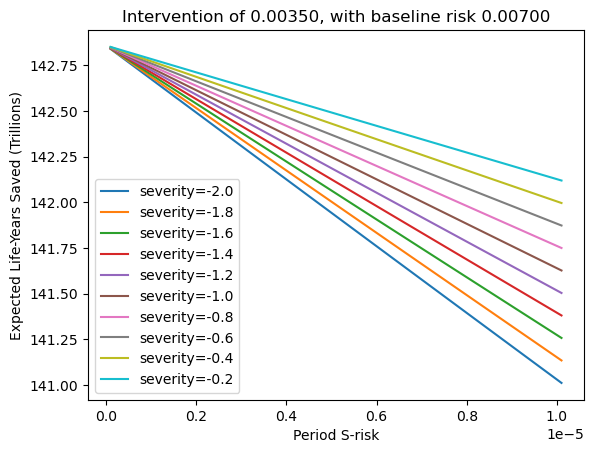

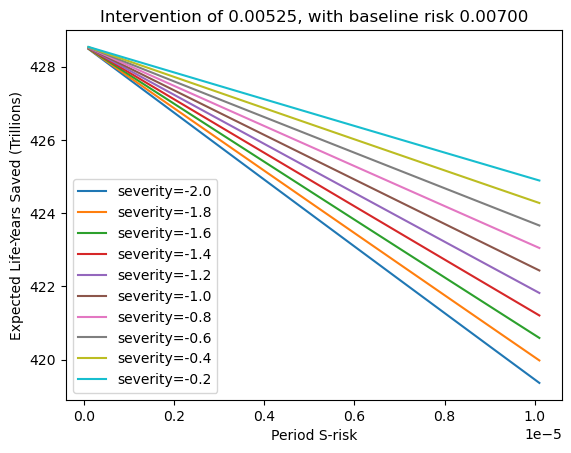

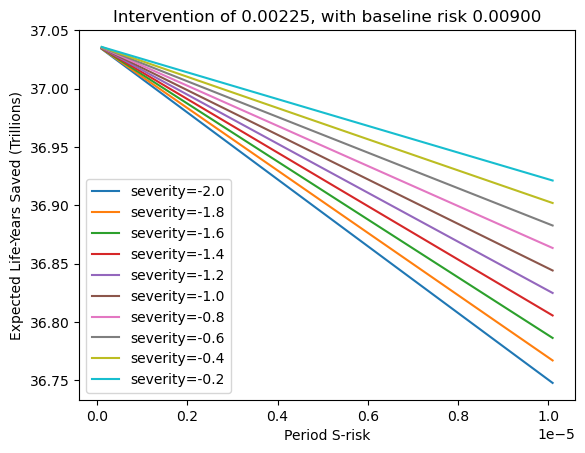

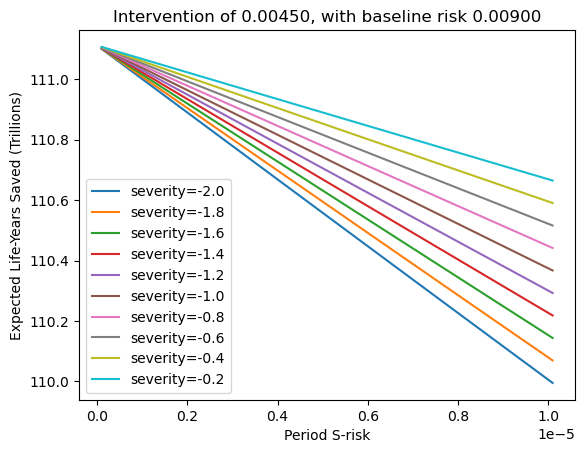

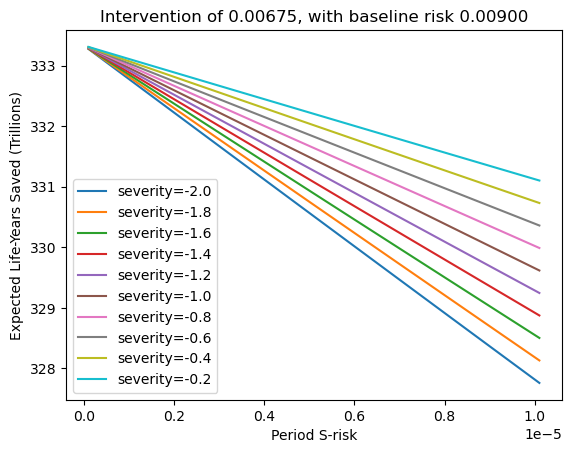

In [21]:
# params
n_periods = 16000
base_risks = np.arange(0.001, 0.011, 0.002)
relative_risk_reduction_factor = 4.0 # determines the sizes (and number) of the intervention effects graphed
s_risk_severities = np.arange(-2, 0, 0.2)
period_s_risks = np.arange(0.0000001, 0.000011, 0.000001)

graph_s_risk_sensitivities(base_risks, relative_risk_reduction_factor, period_s_risks, s_risk_severities, n_periods)

## Time of Perils

In [23]:
def survival_prob_fn(period_num, risk):
    return (1 - risk) ** period_num

def get_impact(intervention_effect, peril_risk, post_peril_risk, num_peril_periods, num_periods):
    # without intervention
    peril_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, peril_risk))
    post_peril_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, post_peril_risk))
    
    peril_probs = peril_prob_fn(np.arange(1, num_peril_periods + 1))
    post_peril_probs = post_peril_prob_fn(np.arange(1, num_periods + 1 - num_peril_periods)) * peril_probs[num_peril_periods - 1]
    base_value = peril_probs.sum() + post_peril_probs.sum()
    
    # with intervention
    peril_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, peril_risk - intervention_effect))
    post_peril_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, post_peril_risk))
    
    peril_probs = peril_prob_fn(np.arange(1, num_peril_periods + 1))
    post_peril_probs = post_peril_prob_fn(np.arange(1, num_periods + 1 - num_peril_periods)) * peril_probs[num_peril_periods - 1]
    intervention_value = peril_probs.sum() + post_peril_probs.sum()
    
    return intervention_value - base_value

def graph_time_of_perils_sensitivities(intervention_effect, peril_risk, post_peril_risks, peril_periods_range, n_periods):
    # heatmap data
    data = np.empty((len(post_peril_risks), len(peril_periods_range)))

    # loop and fill data
    i = 0
    for post_peril_risk in post_peril_risks:
        j = 0
        for num_peril_periods in peril_periods_range:
            data[i][j] = get_impact(intervention_effect, peril_risk, post_peril_risk, num_peril_periods, n_periods)
            j += 1
        i += 1

    sns.heatmap(data, xticklabels=peril_periods_range, yticklabels=list(map(lambda x: f"{x:.5f}", post_peril_risks)), annot=True, linewidths=.5, fmt=".0f")
    sns.set(rc={"figure.figsize":(8, 5)})
    plt.title(f"Peril risk: {peril_risk * 100:.0f}%, Intervention: {intervention_effect * 100:.0f}%", fontsize=20)
    plt.xlabel("Number of periods in the time of perils", fontsize=15)
    plt.ylabel("Period X-risk after time of perils", fontsize=15)
    plt.show()

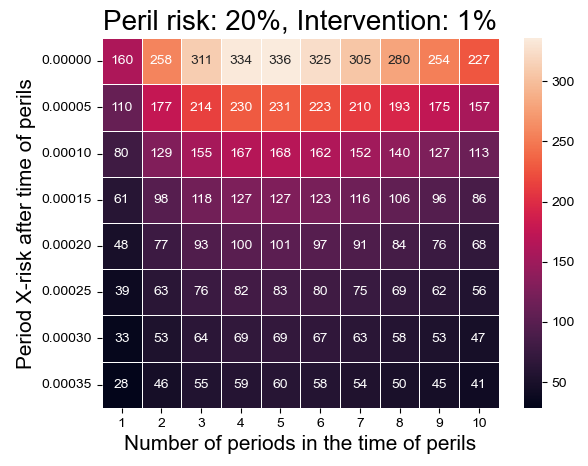

In [24]:
# params
n_periods = 16000
peril_risk = 0.2
intervention_effect = 0.01
post_peril_risks = np.arange(0, 0.00036, 0.00005)
peril_periods_range = np.arange(1, 11, 1)

graph_time_of_perils_sensitivities(intervention_effect, peril_risk, post_peril_risks, peril_periods_range, n_periods)

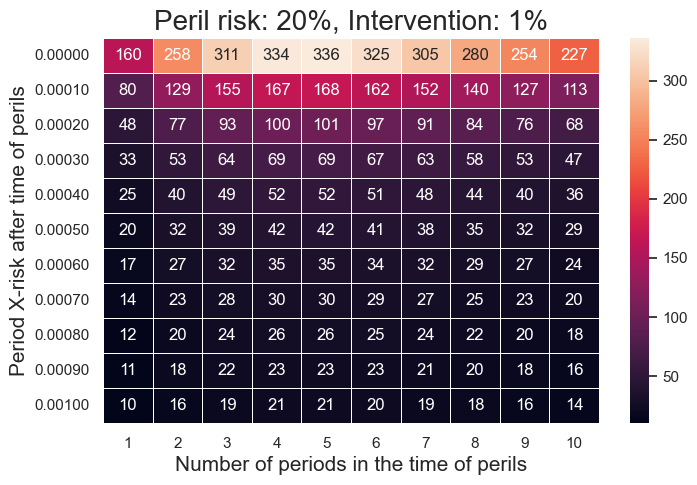

In [25]:
# params
n_periods = 16000
peril_risk = 0.20
intervention_effect = 0.01
post_peril_risks = np.arange(0, 0.0011, 0.0001)
peril_periods_range = np.arange(1, 11, 1)

graph_time_of_perils_sensitivities(intervention_effect, peril_risk, post_peril_risks, peril_periods_range, n_periods)

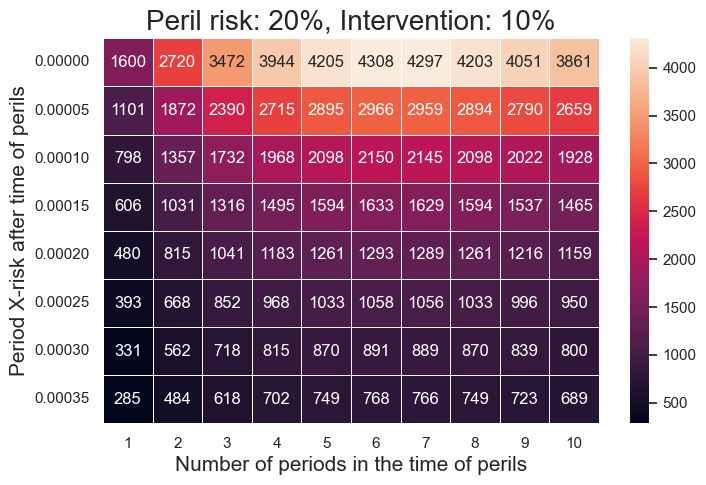

In [26]:
# params
n_periods = 16000
peril_risk = 0.2
intervention_effect = 0.10
post_peril_risks = np.arange(0, 0.00036, 0.00005)
peril_periods_range = np.arange(1, 11, 1)

graph_time_of_perils_sensitivities(intervention_effect, peril_risk, post_peril_risks, peril_periods_range, n_periods)

## Hedonic Lotteries

In [28]:
def survival_prob_fn(period, risk):
    """Returns the probability of surviving through *period, given constant period *risk."""
    return (1 - risk) ** period

def get_value_of_h_lottery_scenario(period_x_risk, num_periods, period_h_chance, h_magnitude):
    # get survival probs for each period
    risk_survival_prob_fn = np.vectorize(lambda period: survival_prob_fn(period, period_x_risk))
    survival_probs = risk_survival_prob_fn(np.arange(1, num_periods + 1))
    
    # get non-s-risk probs for each survival period
    prob_normal_fn = np.vectorize(lambda i: (1-period_h_chance) ** i)
    probs_of_normal = prob_normal_fn(np.arange(1, n_periods + 1))

    # get s-risk probs for each survival period
    probs_of_h_lottery = 1 - probs_of_normal
    
    return (survival_probs * (probs_of_normal + probs_of_h_lottery * h_magnitude)).sum()

def get_h_lottery_intervention_impact(intervention_effect, baseline_risk, num_periods, period_h_chance, h_magnitude):
    if intervention_effect > baseline_risk:
        ValueError("Intervention effect greater than risk.")
    
    # without intervention
    base_value = get_value_of_h_lottery_scenario(baseline_risk, num_periods, period_h_chance, h_magnitude)

    # with intervention
    intervention_value = get_value_of_h_lottery_scenario(baseline_risk - intervention_effect, num_periods, period_h_chance, h_magnitude)

    return intervention_value - base_value

def graph_h_lottery_sensitivities(base_risks, relative_risk_reduction_factor, period_h_chances, h_magnitudes, n_periods):
    for base_risk in base_risks:
        intervention_effects = np.arange(base_risk / relative_risk_reduction_factor, base_risk, base_risk / relative_risk_reduction_factor)
        for intervention_effect in intervention_effects:
            if intervention_effect == base_risk:
                continue
            for h_magnitude in h_magnitudes:
                impacts = []
                for period_h_chance in period_h_chances:
                    impacts += [get_h_lottery_intervention_impact(intervention_effect, base_risk, n_periods, period_h_chance, h_magnitude)]
                # add line for (s-risk chance, severity) pair to graph for current (baseline risk, intervention effect) pair
                plt.plot(period_h_chances, impacts, label=f"magnitude={h_magnitude:.1f}")

            # Create graph for given (baseline risk, intervention effect) pair
            plt.legend()
            plt.title(f"Intervention of {intervention_effect:.5f}, with baseline risk {base_risk:.5f}")
            plt.ylabel("Expected Life-Years Saved (Trillions)")
            plt.xlabel("Period Hedonic Lottery Chance")
            plt.show()

### Larger Hedonic Lottery Chances

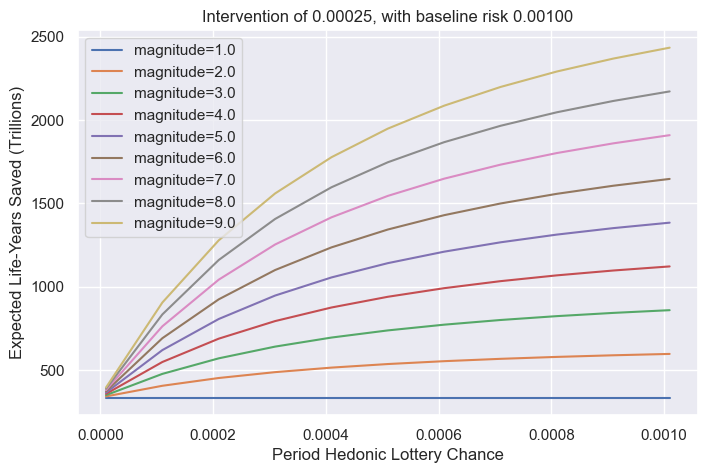

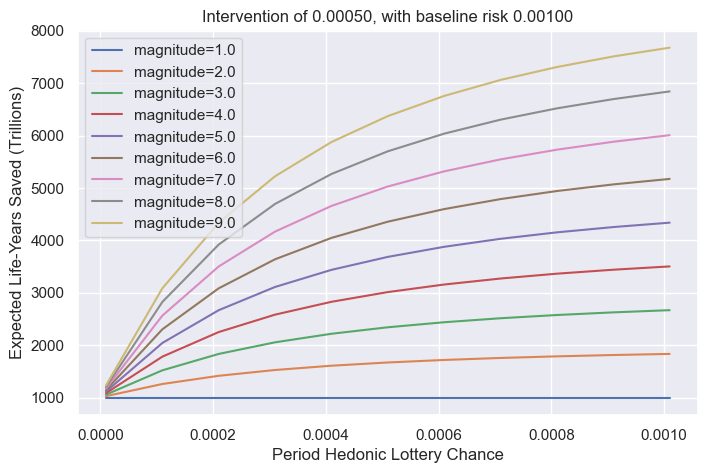

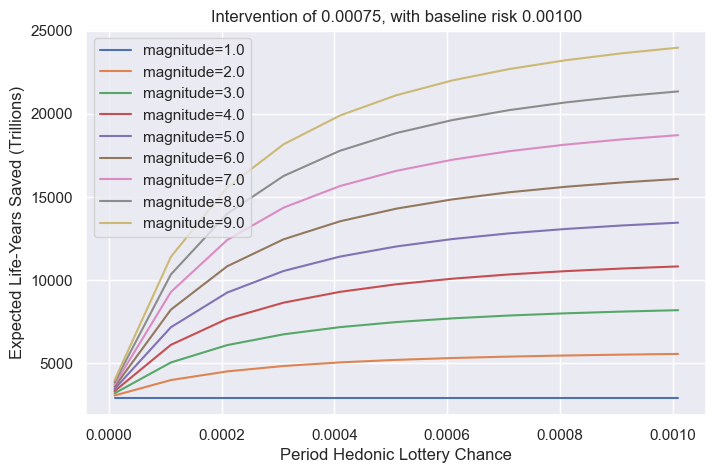

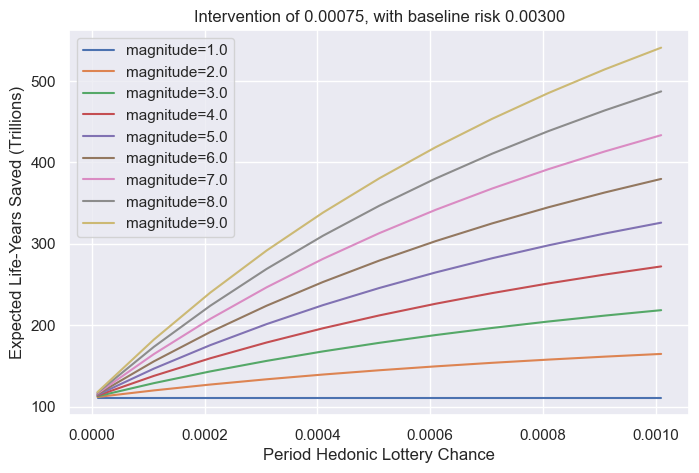

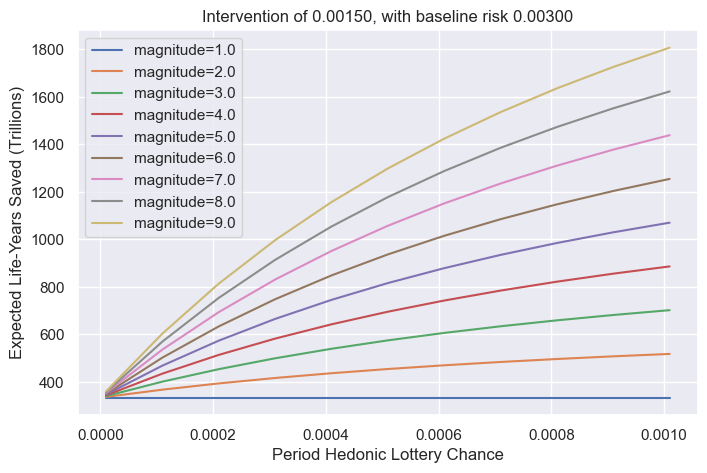

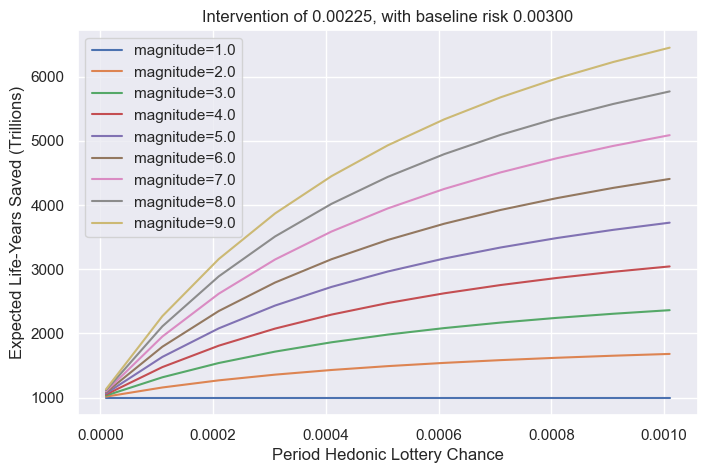

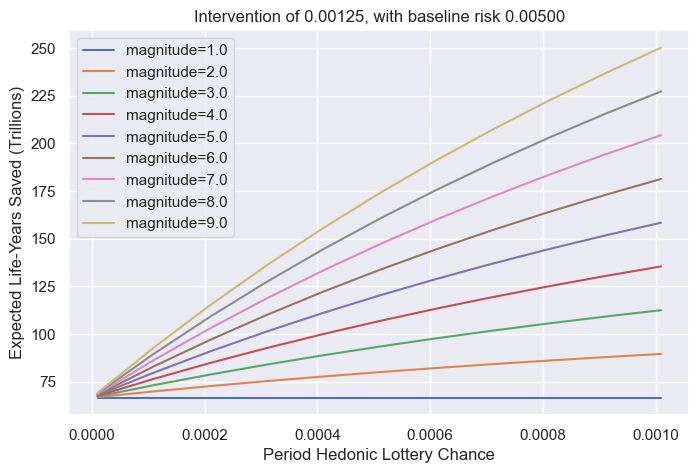

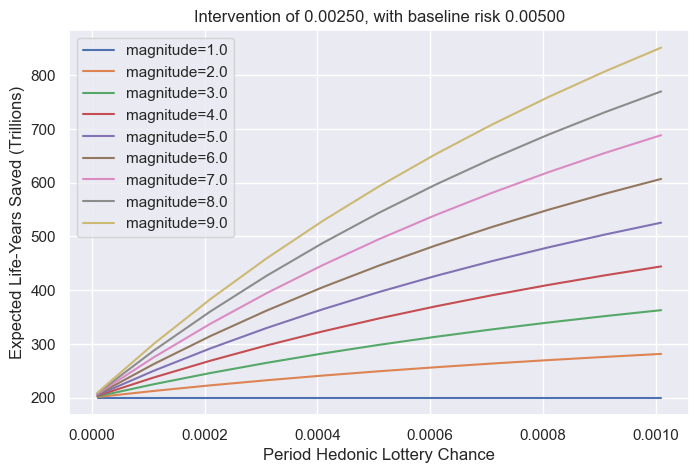

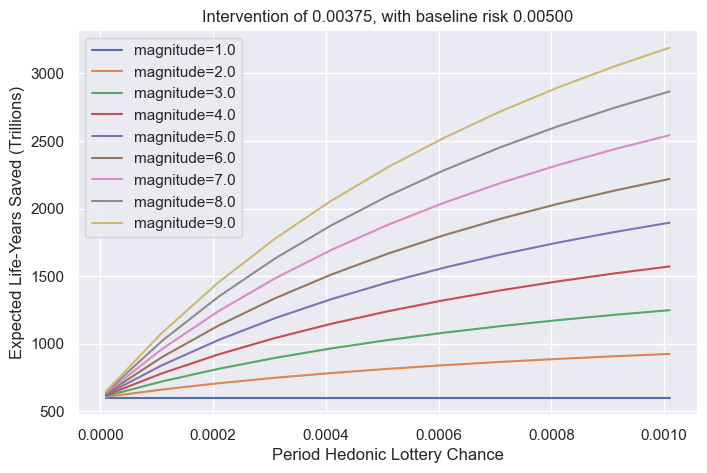

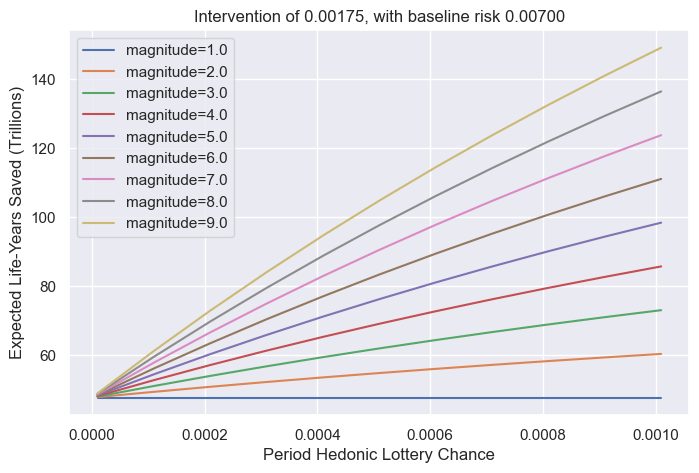

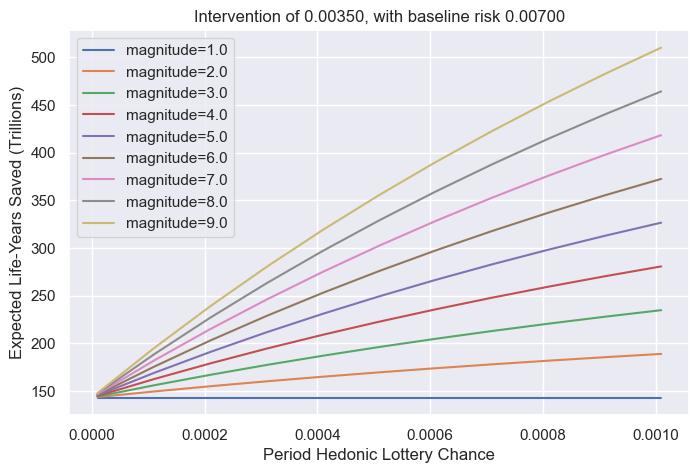

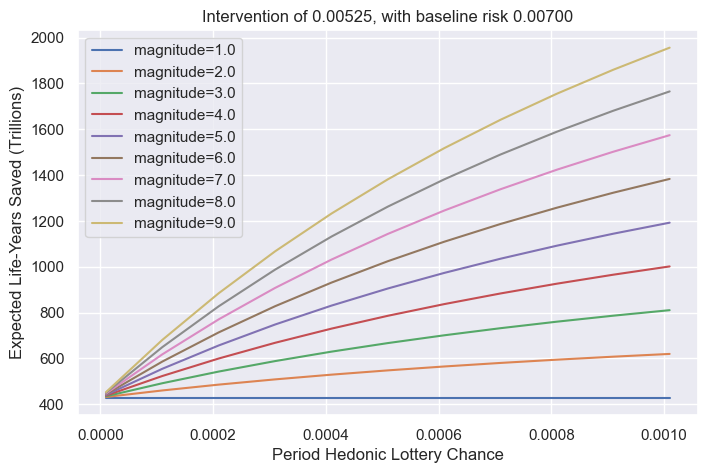

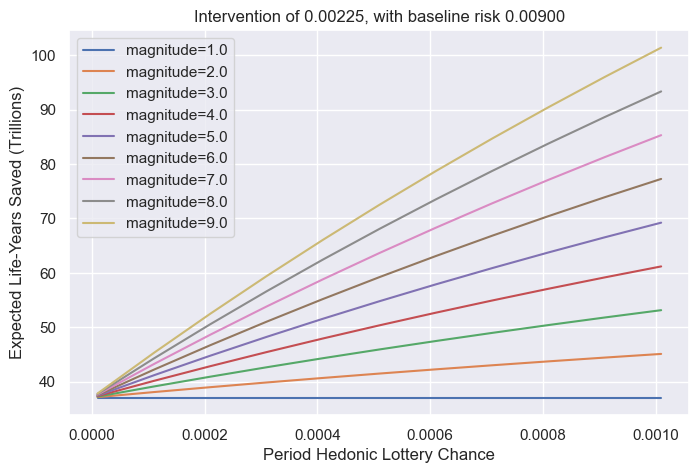

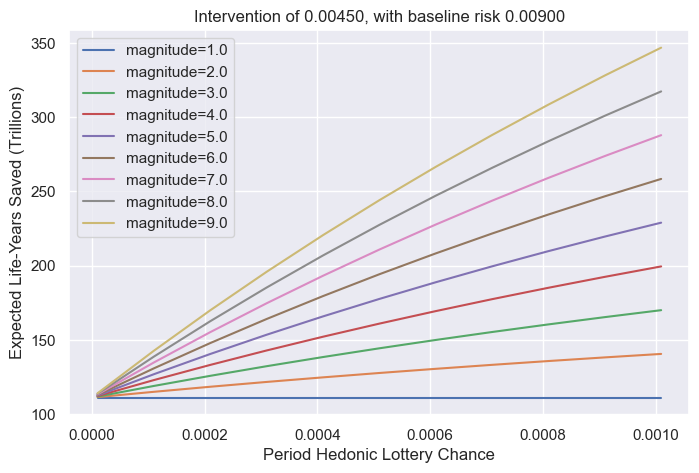

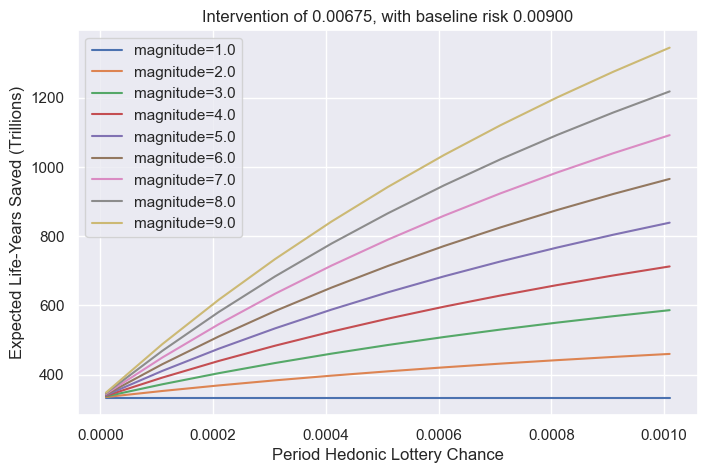

In [31]:
# params
n_periods = 16000
base_risks = np.arange(0.001, 0.011, 0.002)
relative_risk_reduction_factor = 4.0 # determines the relative sizes (and number) of the intervention effects graphed
h_magnitudes = np.arange(1, 10, 1)
period_h_chances = np.arange(0.00001, 0.0011, 0.0001)

graph_h_lottery_sensitivities(base_risks, relative_risk_reduction_factor, period_h_chances, h_magnitudes, n_periods)

### Smaller Hedonic Lottery Chances

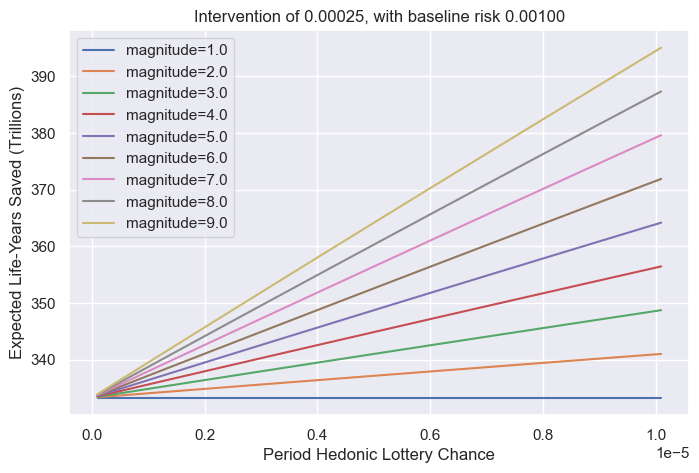

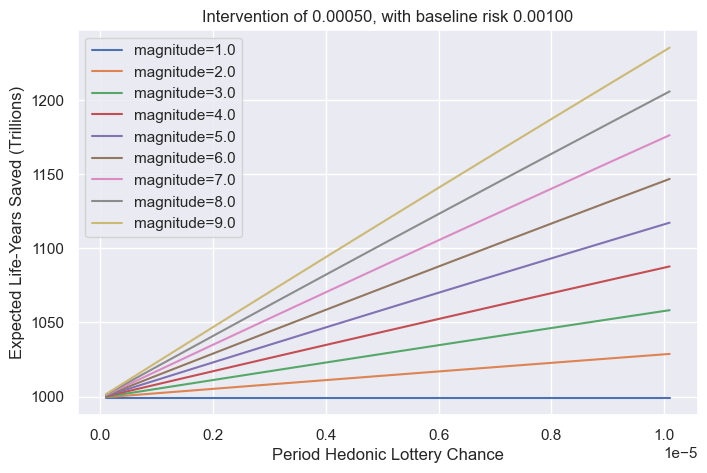

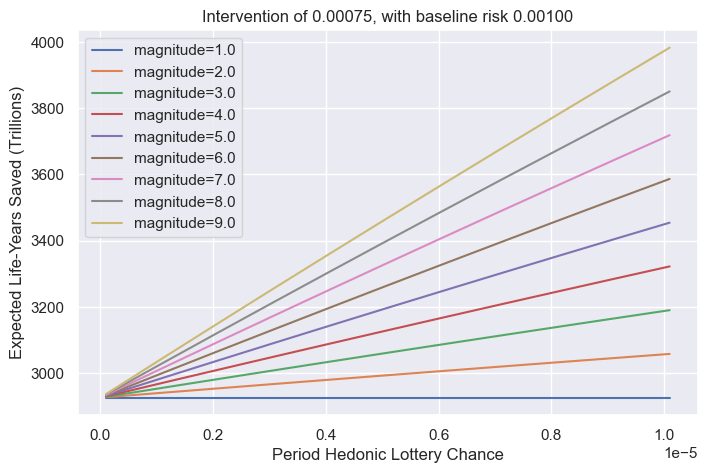

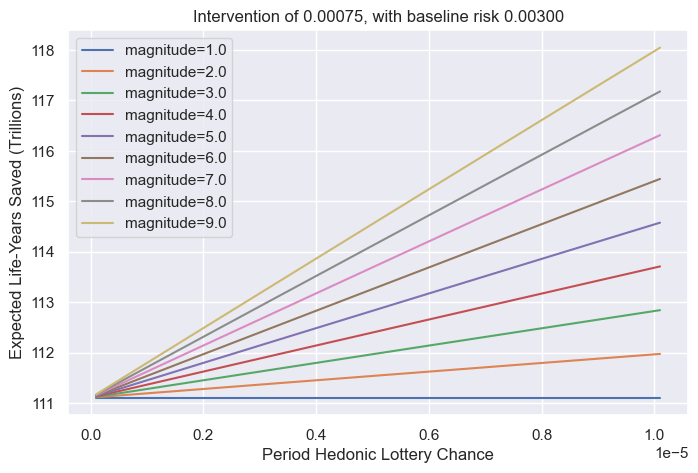

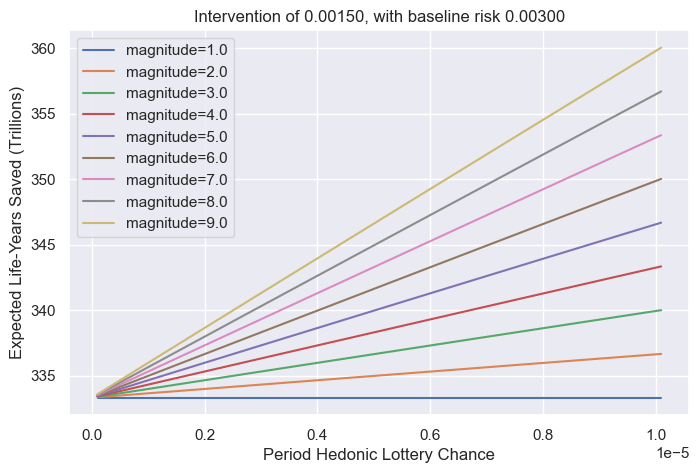

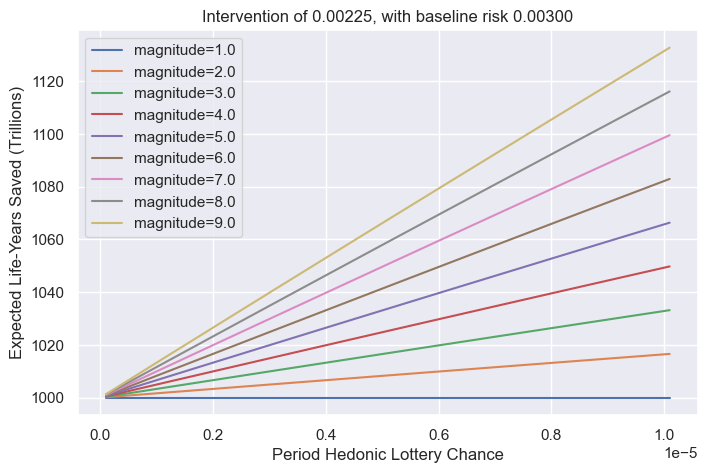

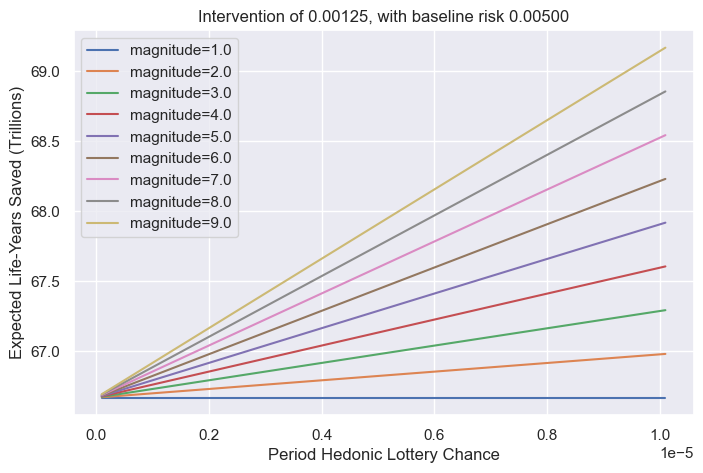

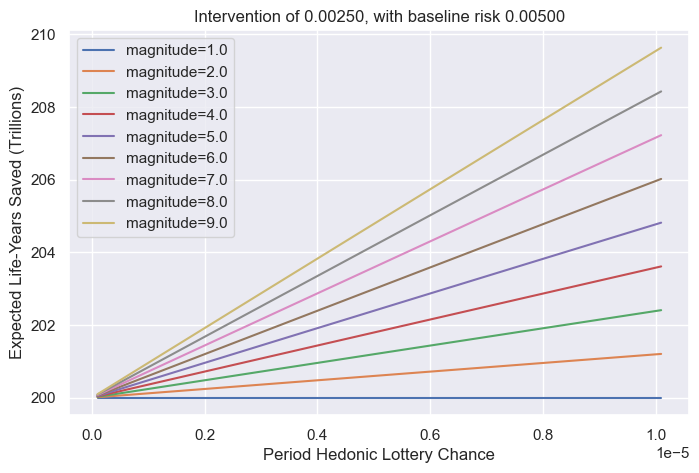

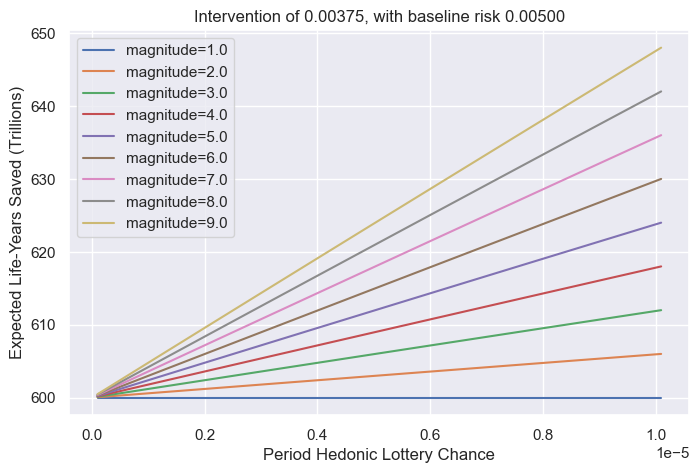

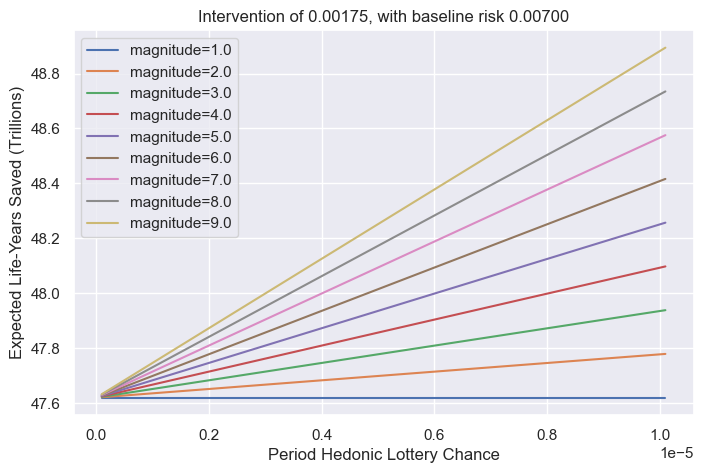

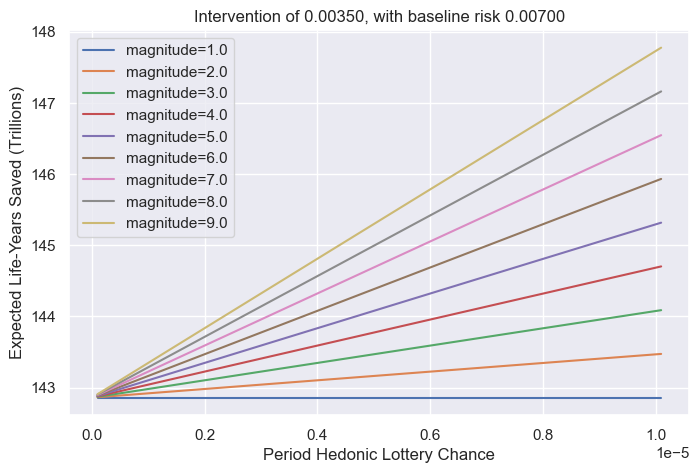

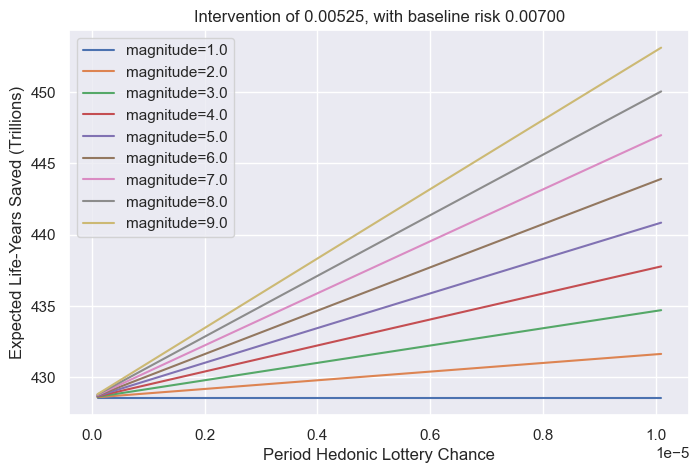

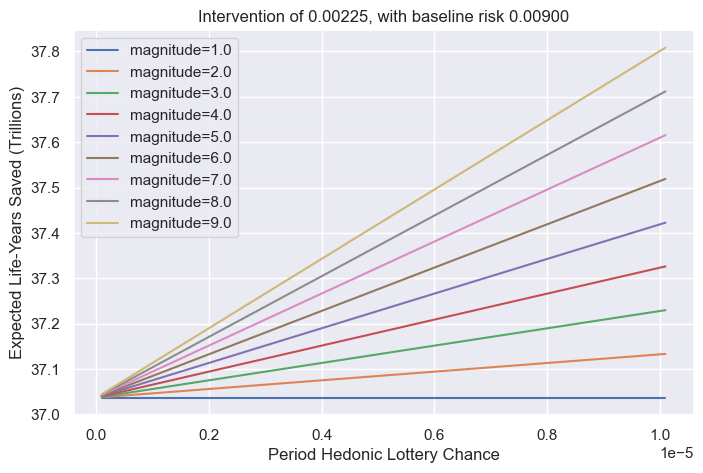

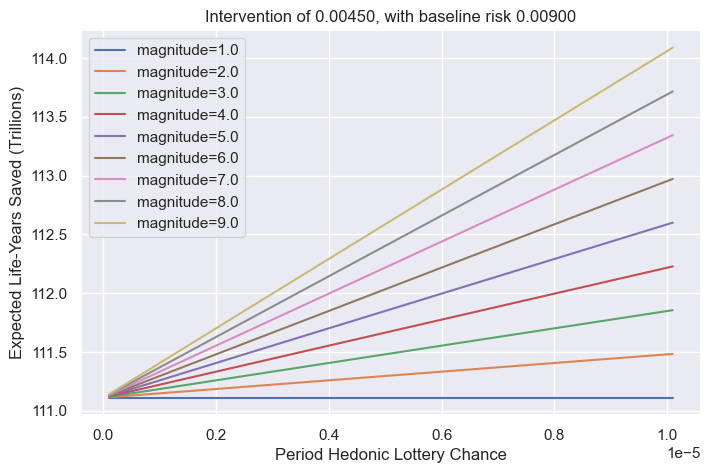

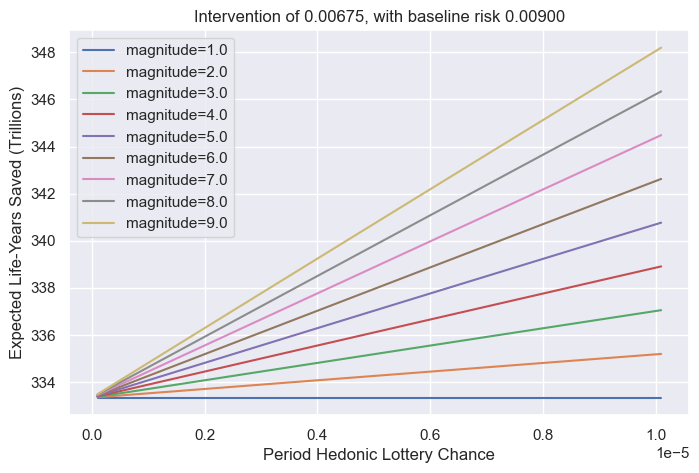

In [34]:
# params
n_periods = 16000
base_risks = np.arange(0.001, 0.011, 0.002)
relative_risk_reduction_factor = 4.0 # determines the relative sizes (and number) of the intervention effects graphed
h_magnitudes = np.arange(1, 10, 1)
period_h_chances = np.arange(0.0000001, 0.000011, 0.000001)

graph_h_lottery_sensitivities(base_risks, relative_risk_reduction_factor, period_h_chances, h_magnitudes, n_periods)